In [ ]:
!pip install git+https://github.com/pe8sutd/eda4u &> /dev/null
!git clone https://github.com/pe8sutd/eda4u &> /dev/null
%load_ext plugin

The plugin extension is already loaded. To reload it, use:
  %reload_ext plugin


FPGA Project
Vivado Setup

Create a project for CMOD A7-35T.
Verilog Implementation

Constraint File (.xdc)

Bitstream & Programming

Generate and flash the bitstream to the FPGA.
Testing & Documentation

Debug using onboard LEDs/UART output.

# **Video Demo**
Explantion: In these videos we show the LED display works physically and show that we can collect the digital data via Python.


Link to physical test

https://github.com/LeowYR/DSL_Homework/blob/main/Task03%20CMOD%20A7%20sensor%20test.mp4


Link to Python test

https://github.com/LeowYR/DSL_Homework/blob/main/Task03%20CMOD%20A7%20sensor%20python%20test.mp4

# **Logic-gate Code**

For the logic gate FPGA, our code used in the program is shown below. It was created by TA Mao Yang to test the CMOD FPGA being used in the current iteration


In [ ]:
%%verilog
// Module: top_module
 //  Date : 2024/03/21
 //  Author : Maoyang
 // Description:
 // This top-level module integrates various components to demonstrate a complete system design,
 // including a clock divider, a 7-segment display driver, and an external ADC (Analog-to-Digital Converter) MCP3202 interface.
 // The system operates based on the input from a system clock (sysclk) and two buttons (btn).
 // Inputs:
 // - sysclk: The system clock input.
 // - btn: 2-button input for system control. btn[1] is used as a reset signal.
 // - adc_dout: Digital output from the MCP3202 ADC.
 //
 // Outputs:
 // - pio37 to pio48: Pins connected to a 7-segment display for displaying ADC data.
 // - led: 2-bit LED output for indicating system status or errors (not implemented in the given code).
 // - adc_din: Serial data input to the ADC.
 // - adc_clk: Clock signal for the ADC.
 // - adc_csn: Chip select signal for the ADC, active low.
 //
 // Functionality:
 // 1. The module starts with configuring the system reset based on the btn[1] input.
 // 2. It then sets up three clock dividers to generate different frequencies needed for the 7-segment display and the ADC.
 // 3. The 7-segment display is driven by the `drv_segment` module, which updates the display based on the ADC data.
 // 4. The MCP3202 ADC is configured to operate in single channel mode (CHANNEL 0), with a 2MHz clock.
 // 5. ADC sampling occurs at a frequency of 1Hz, triggered by the CLK1Hz signal. When new ADC data is valid (adc_vaild), it is displayed on the 7-segment display.
 //
 // Implementation Details:
 // - Clock division is achieved using instances of the `clock_div` module, parameterized to produce the required frequencies for the ADC and the 7-segment display.
 // - The 7-segment display configuration and updating are handled by the `drv_segment` module.
 // - The `drv_mcp3202` module interfaces with the MCP3202 ADC, handling the SPI communication and data conversion process.
 // - The ADC sampling and display update logic is implemented in an always block, which reacts to the ADC's valid data signal and the 1Hz clock signal.
 //
 // Notes:
 // - This module demonstrates handling of digital and analog inputs, clock management, and driving peripheral devices in a hardware description language.
 //

module uart_tx (
    input clk,           // System clock
    input rst,           // Reset signal
    input [7:0] data_in, // Byte to send
    input send,          // Pulse to start sending
    output reg tx,       // UART TX line
    output reg busy      // High when transmitting
);
    // Add implementation for UART TX here...
endmodule




module top_module(
        input sysclk,
        input [1:0] btn,
        output pio37,
        output pio38,
        output pio39,
        output pio40,
        output pio41,
        output pio42,
        output pio43,
        output pio44,
        output pio45,
        output pio46,
        output pio47,
        output pio48,
        output [1:0] led,
        //External ADC MCP3202 Pin;
        output adc_din,
        output adc_clk,
        output adc_csn,
        input  adc_dout,
        //UART Tx Pin;
        output uart_rxd_out
);

uart_tx uart_inst (
        .clk(clk),
        .rst(rst),
        .data_in(data),
        .send(send),
        .tx(tx),
        .busy(busy)
    );

//RESET SYSTEM CONFIG;
wire rstn;
assign rstn = ~btn[1];

//CLOCK TREE CONFIG;
wire CLK500Hz,CLK1Hz,CLK_ADC,CLK_UART,CLK2Hz;

clock_div clk_div_u1(rstn,sysclk,CLK500Hz);
clock_div clk_div_u2(rstn,CLK500Hz,CLK1Hz);
clock_div clk_div_u3(rstn,sysclk,CLK_ADC);
clock_div clk_div_u4(rstn,sysclk,CLK_UART);
clock_div clk_div_u5(rstn,sysclk,CLK2Hz);

defparam clk_div_u1.FREQ_INPUT  = 12_000_000;
defparam clk_div_u1.FREQ_OUTPUT = 500;
defparam clk_div_u2.FREQ_INPUT  = 500;
defparam clk_div_u2.FREQ_OUTPUT = 1;
defparam clk_div_u3.FREQ_INPUT  = 12_000_000;
defparam clk_div_u3.FREQ_OUTPUT = 2_000_000;
defparam clk_div_u4.FREQ_INPUT  = 12_000_000;
defparam clk_div_u4.FREQ_OUTPUT = 9600;
defparam clk_div_u5.FREQ_INPUT  = 12_000_000;
defparam clk_div_u5.FREQ_OUTPUT = 2;

//7SEGMENT DISPLAY CONFIG;
reg [11:0] Segment_data;
drv_segment segment_u0(rstn,CLK500Hz,{4'h0,Segment_data},{pio43,pio46,pio47,pio37},{pio40,pio38,pio45,pio42,pio41,pio39,pio48,pio44});

//EXTERNAL ADC MCP3202 CONFIG;
// DRV FREQ : 2MHZ;
// CHANNEL : ONLY CHANNEL 0;
localparam  SINGLE_CHAN0  = 2'b10;
localparam  SINGLE_CHAN1  = 2'b11;

reg adc_ready;
wire adc_vaild;
wire [11:0] adc_data;

drv_mcp3202 drv_mcp3202_u0(
    .rstn(rstn),
    .clk(CLK_ADC),
    .ap_ready(adc_ready),
    .ap_vaild(adc_vaild),
    .mode(SINGLE_CHAN0),
    .data(adc_data),

    .port_din(adc_dout),
    .port_dout(adc_din), //adc_din
    .port_clk(adc_clk),
    .port_cs(adc_csn)
);

// ADC SAMPLING EVENT (FREQ:1HZ)
always @(negedge rstn, posedge adc_vaild,posedge CLK1Hz) begin
    if(!rstn) begin
        adc_ready <= 1'b0;
        Segment_data <= 12'hABC;
    end else begin
        if(adc_vaild) begin
            Segment_data <= adc_data;
            adc_ready <= 1'b0;
        end
        else begin
            adc_ready <= 1'b1;
        end
    end
end


//UART Tx Event Config (FREQ:9600)

reg uart_ready;
wire uart_vaild;
reg [7:0] uart_data;
reg hl_sel;

drv_uart_tx drv_uart_u0(
    .clk(CLK_UART),
    .ap_rstn(rstn),
    .ap_ready(uart_ready),
    .ap_vaild(uart_vaild),
    .tx(uart_rxd_out),
    .pairty(1'b0),
    .data(uart_data)
);

always @(negedge rstn, posedge uart_vaild,negedge CLK2Hz) begin
    if(!rstn) begin
        uart_ready <= 1'b0;
        hl_sel <= 1'b0;
    end else begin
        if(uart_vaild) begin
            uart_data <= (hl_sel)? {4'h0, Segment_data[11:8]}: Segment_data[7:0];
            uart_ready   <= 1'b0;
        end
        else begin
            uart_ready  <= 1'b1;
            hl_sel      <= ~hl_sel;
        end
    end
end


endmodule


                                    module clock_div(
    input rstn,
    input clksrc,
    output clkout
);

parameter FREQ_INPUT  = 12_000_000;
parameter FREQ_OUTPUT = 1_000;
parameter CNTER_MAX = FREQ_INPUT/(FREQ_OUTPUT*2);
parameter CNTER_WIDTH = $clog2(CNTER_MAX);

reg clkout_r;
reg [CNTER_WIDTH-1:0] cnter;
assign clkout = clkout_r;

always @(negedge rstn,posedge clksrc) begin
    if(!rstn)begin
        cnter <= {CNTER_WIDTH{1'b0}};
        clkout_r <= 1'b0;
    end
    else begin
        if(cnter == CNTER_MAX - 1'b1)begin
            clkout_r <= ~clkout_r;
            cnter <= {CNTER_WIDTH{1'b0}};
        end
        else begin
            cnter <= cnter + 1'b1;
        end
    end
end

endmodule

                                  module drv_segment(
    input rstn,
    input clk500hz,
    input [15:0] bcd_num,
    output [3:0] an,
    output [7:0] segment
);

reg [7:0] segment_r;
reg [3:0] an_r;
assign segment = ~ segment_r;
reg [3:0] cur_num_r;        //Register - BCD Number Display at this moment;
assign an = ~an_r;
//Drive 7Segment Anode;
//When an_r == 0001, DIG4 will turn on;
//When an_r == 0001, at posedge clk500hz, an_r will be set to 0010(DIG3 ON);
//When an_r == 0010, at posedge clk500hz, an_r will be set to 0100(DIG2 ON);
//....
//DIG4 -> DIG3 -> DIG2 -> DIG1 -> DIG4 -> DIG3 -> DIG2 -> ...;
always @(negedge rstn,posedge clk500hz)begin
    if(!rstn)begin
        an_r <= 4'b0000;    //When system reset, empty all display;
    end
    else begin
        case(an_r)
        4'b0001: an_r <= 4'b0010;   //DISPLAY ON DIG3
        4'b0010: an_r <= 4'b0100;   //DISPLAY ON DIG2
        4'b0100: an_r <= 4'b1000;   //DISPLAY ON DIG1
        default: an_r <= 4'b0001;   //DISPLAY ON DIG4
        endcase
    end
end

//When DIG4 on, BCD Number Display at this moment is bcd_num[3:0];  (i.e Stop Watch - Second Unit)
//When DIG3 on, BCD Number Display at this moment is bcd_num[7:4];  (i.e Stop Watch - Second Decade)
//When DIG2 on, BCD Number Display at this moment is bcd_num[11:8]; (i.e Stop Watch - Minute Unit)
//When DIG1 on, BCD Number Display at this moment is bcd_num[15:12];(i.e Stop Watch - Minute Decade)
always @(an_r,bcd_num)begin
    case(an_r)
        4'b0001: cur_num_r <= bcd_num[3:0];
        4'b0010: cur_num_r <= bcd_num[7:4];
        4'b0100: cur_num_r <= bcd_num[11:8];
        4'b1000: cur_num_r <= bcd_num[15:12];
        default: cur_num_r <= 4'b0;
    endcase
end

//Decode BCD NUM into corrosponding 7Segment Code;
always @(cur_num_r) begin
    case(cur_num_r)
        4'h0:segment_r <= 8'hc0;    //NUM "0"
        4'h1:segment_r <= 8'hf9;    //NUM "1"
        4'h2:segment_r <= 8'ha4;    //NUM "2"
        4'h3:segment_r <= 8'hb0;    //NUM "3"
        4'h4:segment_r <= 8'h99;    //NUM "4"
        4'h5:segment_r <= 8'h92;    //NUM "5"
        4'h6:segment_r <= 8'h82;    //NUM "6"
        4'h7:segment_r <= 8'hF8;    //NUM "7"
        4'h8:segment_r <= 8'h80;    //NUM "8"
        4'h9:segment_r <= 8'h90;    //NUM "9"
        4'ha:segment_r <= 8'h88;    //NUM "A" - HEX NUMBER DISPLAY
        4'hb:segment_r <= 8'h83;    //NUM "b"
        4'hc:segment_r <= 8'hc6;    //NUM "C"
        4'hd:segment_r <= 8'ha1;    //NUM "D"
        4'he:segment_r <= 8'h86;    //NUM "E"
        4'hf:segment_r <= 8'h8e;    //NUM "F"
        default: segment_r <= 8'hff;
    endcase
end

endmodule

       module drv_mcp3202(
    input rstn,
    input clk,
    input   ap_ready,
    output  reg ap_vaild,
    input   [1:0] mode,
    output  [11:0] data,

    input   port_din,
    output  reg port_dout,
    output  port_clk,
    output  reg port_cs
);

wire    [3:0]      Data_Transmit; // 4 bits CONTROL;
reg     [12:0]     Data_Receive;  // 1 bit NULL + 12 bits DATA;

assign Data_Transmit[3]    = 1'b1;
assign Data_Transmit[0]    = 1'b1;
assign Data_Transmit[2:1] = mode;

reg [1:0]   fsm_statu,fsm_next;
localparam FSM_IDLE = 2'b00;
localparam FSM_WRIT = 2'b10;
localparam FSM_READ = 2'b11;
localparam FSM_STOP = 2'b01;

reg [1:0] cnter_writ;
reg [3:0] cnter_read;

//FSM statu transfer;
always @(posedge clk, negedge rstn) begin
    if (!rstn)  fsm_statu <= FSM_IDLE;
    else        fsm_statu <= fsm_next;
end

//FSM Transfer Condition;
always @(*)begin
    if(!rstn) fsm_next <= FSM_IDLE;
    else begin
        case (fsm_statu)
            FSM_IDLE : fsm_next <= (ap_ready)? FSM_WRIT : FSM_IDLE;
            FSM_WRIT : fsm_next <= (2'd0 == cnter_writ)? FSM_READ : FSM_WRIT;
            FSM_READ : fsm_next <= (2'd0 == cnter_read)? FSM_STOP : FSM_READ;
            FSM_STOP : fsm_next <= (!ap_ready)? FSM_STOP : FSM_IDLE;
            default  : fsm_next <= FSM_IDLE;
        endcase
    end
end

//FSM Output - SPI Write Data
always @(negedge rstn,negedge clk)begin
    if (!rstn) begin
        cnter_writ  <= 2'd3;
        port_dout   <= 1'b1;
        port_cs     <= 1'b1;
    end else begin
        case (fsm_statu)
            FSM_IDLE : begin
                cnter_writ  <= 2'd3;
                port_dout   <= 1'b1;
                port_cs     <= 1'b1;
            end
            FSM_WRIT : begin
                port_cs     <= 1'b0;
                port_dout   <= Data_Transmit[cnter_writ];
                cnter_writ  <= cnter_writ - 1'b1;
            end
            FSM_READ : begin
                port_cs     <= 1'b0;
                port_dout   <= 1'b1;
            end
            FSM_STOP : port_cs     <= 1'b1;
            default  : ;
        endcase
    end
end

//FSM Output - SPI Read  Data
always @(negedge rstn,posedge clk)begin
    if (!rstn) begin
        cnter_read  <= 4'd13;
        Data_Receive <= 13'h00;
        ap_vaild = 1'b0;
    end else begin
        case (fsm_statu)
            FSM_IDLE : begin
                ap_vaild = 1'b0;
                cnter_read  <= 4'd13;
            end
            FSM_WRIT : begin
                Data_Receive <= 13'h00;
            end
            FSM_READ : begin
                cnter_read <= cnter_read - 1'b1;
                Data_Receive[cnter_read] <= port_din;
            end
            FSM_STOP : ap_vaild = 1'b1;
            default  : ;
        endcase
    end
end

assign port_clk = clk | port_cs;
assign data = Data_Receive[11:0];

endmodule

        module drv_uart_tx(
    input   clk,
    input   ap_rstn,
    input   ap_ready,
    output  reg ap_vaild,
    output  reg tx,
    input   pairty,
    input  [7:0] data
);

localparam  FSM_IDLE = 3'b000,
            FSM_STAR = 3'b001,
            FSM_TRSF = 3'b010,
            FSM_PARI = 3'b011,
            FSM_STOP = 3'b100;

reg [2:0] fsm_statu;
reg [2:0] fsm_next;
reg [2:0] cnter;

//fsm statu transfer;
always @(posedge clk, negedge ap_rstn) begin
    if (!ap_rstn)begin
        fsm_statu <= FSM_IDLE;
    end else begin
        fsm_statu <= fsm_next;
    end
end

//fsm conditional transfer;
always @(*)begin
    if(!ap_rstn)begin
        fsm_next <= FSM_IDLE;
    end else begin
        case(fsm_statu)
            FSM_IDLE:begin
                fsm_next <= (ap_ready) ? FSM_STAR : FSM_IDLE;
            end
            FSM_STAR: fsm_next <= FSM_TRSF;
            FSM_TRSF:begin
                fsm_next <= (cnter == 3'h7) ? (pairty?FSM_PARI:FSM_STOP) : FSM_TRSF;
            end
            FSM_PARI: fsm_next <= FSM_STOP;
            FSM_STOP:begin
                fsm_next <= (!ap_ready) ? FSM_IDLE : FSM_STOP;
            end
            default: fsm_next <= FSM_IDLE;
        endcase
    end
end

//fsm - output
always @(posedge clk, negedge ap_rstn)begin
    if(!ap_rstn)begin
        ap_vaild <= 1'b0;
        tx <= 1'b1;
        cnter <= 3'h0;
    end else begin
        case (fsm_statu)
            FSM_IDLE: begin
                tx <= 1'b1;
                ap_vaild <= 1'b0;
            end
            FSM_STAR: begin
                tx <= 1'b0;
                cnter <= 3'h0;
            end
            FSM_TRSF: begin
                tx <= data[cnter];
                cnter <= cnter + 1'b1;
            end
            FSM_PARI: tx <= (^data); //Parity Check - ODD Check;
            FSM_STOP: begin
                tx <= 1'b1;         //Stop Bit;
                ap_vaild <= 1'b1;
            end
        endcase
    end
end

endmodule

Test bench

In [ ]:
module top_module_tb;

    // input
    reg sysclk;
    reg [1:0] btn;
    reg adc_dout;

    // out
    wire pio37, pio38, pio39, pio40, pio41, pio42;
    wire pio43, pio44, pio45, pio46, pio47, pio48;
    wire [1:0] led;
    wire adc_din, adc_clk, adc_csn;
    wire uart_rxd_out;

    top_module uut (
        .sysclk(sysclk),
        .btn(btn),
        .pio37(pio37),
        .pio38(pio38),
        .pio39(pio39),
        .pio40(pio40),
        .pio41(pio41),
        .pio42(pio42),
        .pio43(pio43),
        .pio44(pio44),
        .pio45(pio45),
        .pio46(pio46),
        .pio47(pio47),
        .pio48(pio48),
        .led(led),
        .adc_din(adc_din),
        .adc_clk(adc_clk),
        .adc_csn(adc_csn),
        .adc_dout(adc_dout),
        .uart_rxd_out(uart_rxd_out)
    );

    // Generate system clock (e.g. 12MHz → 83.33ns period)
    always #41.66 sysclk = ~sysclk;

    // simulate ADC behavior (simply)
    initial begin
        adc_dout = 0;
        forever begin
            wait (adc_clk == 1); // rising edge of ADC clock
            adc_dout = $random % 2;
            #1;
        end
    end

    initial begin
        $dumpfile("top_tb.vcd");
        $dumpvars(0, top_module_tb);

        sysclk = 0;
        btn = 2'b11;   // both buttons unpressed
        #100;
        btn[1] = 0;    // reset
        #200;
        btn[1] = 1;    // release reset
        #500000;
        $finish;
    end

endmodule


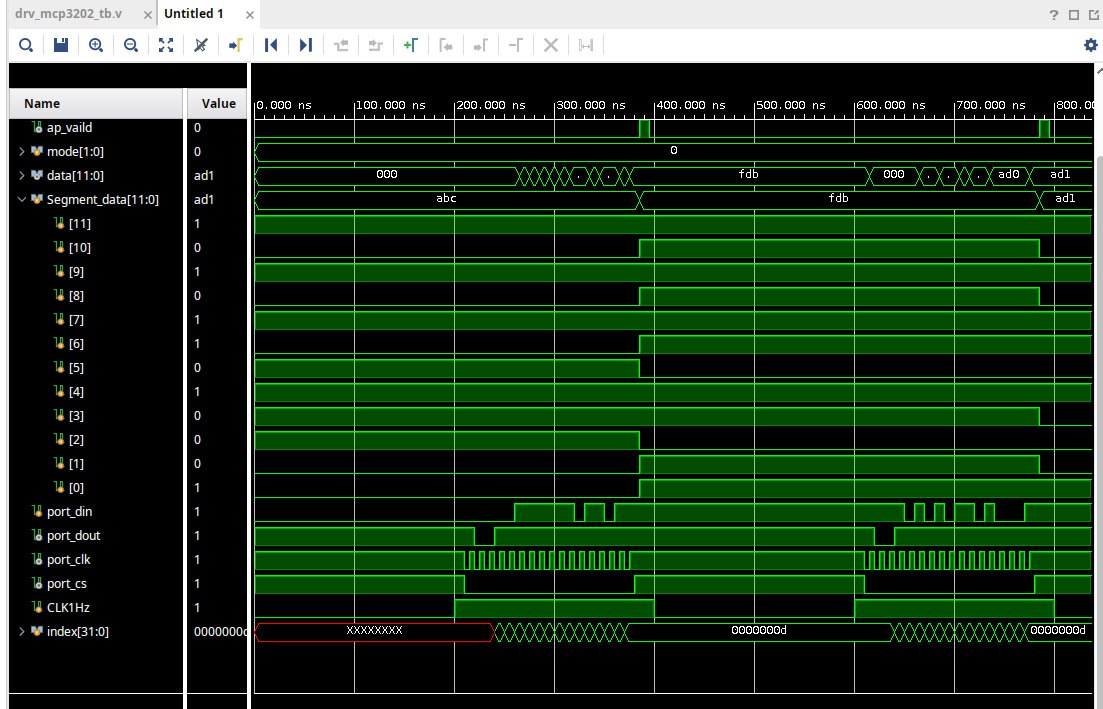Testbench Waveform

The code was then written to read the UART from the serial port of the computer, allowing us to check the data in realtime, with a slight delay, to the LED display.

In [ ]:
import serial
import time

# Open the serial port
ser = serial.Serial('/dev/ttyUSB1', 9600, timeout=1)

print("Listening for split 8-bit UART values...")

try:
    while True:
        # Read first byte: upper 8 bits
        high = ser.read()
        if not high:
            continue

        # Wait for second byte: lower 4 bits (padded)
        low = ser.read()
        if not low:
            continue

        # Convert bytes to ints
        high_val = high[0]
        low_val  = low[0] & 0x0F  # mask to lower 4 bits

        # Recombine to get original 12-bit value
        adc_value = (high_val << 8) | low_val

        print(f"ADC: {adc_value} (0x{adc_value:03X})")

except KeyboardInterrupt:
    print("\nExiting...")
    ser.close()



Using this code, we were able to identify and the data being sent to the LED display and ensure it was accurate. For testing we used the temperature sensor as it was less volatile in the data reading. This provided us with a easier way to ensure that the UART and the LED data displayed was the same.

# Usage of AI and Design challenges



Used AI to understand the code that TA Maoyang wrote.
> Add blockquote

